# Projeto 3 - Ciência dos Dados

#### Stephanie Wertheimer, Thomas Pilnik e Victor Sznifer

Nesse projeto, temos duas bases de dados: uma com dados laboratoriais a respeito quantidade de E. Coli presente na água das praias de Chicago, Illinois, EUA e outra que mensura diferentes características físicas da água, ambas em diferentes datas e horários. 

Nosso objetivo é buscar uma relação entre a proliferação de bactérias e os parâmetros físicos utilizados para analisar a água. Faremos isso usando um modelo de regressão linear e analisando a relação entre a concentração de bactérias e as diferentes variáveis físicas presentes na base de dados. 

A hipótese inicial (H0) é que as variáveis das características físicas da não água têm relação com a concentração de bactérias na água. Estatisticamente isso quer dizer que os betas na regressão linear são iguais a zero, ou seja, que não existe uma correlação. Portanto, nossa hipótese alternativa (H1) é de que as variáveis das características físicas da água têm relação com a concentração de bactérias na água, ou seja, que os betas na regressão linear são diferentes de zero. 
Pretendemos confirmar ou rejeitar nossa hipótese inicial por meio da regressão linear e teste de hipóteses que será feito a seguir.


$$H_0: \beta_i=0$$ $$não $$ $$existe$$ $$correlação$$

$$H_1: \beta_i\neq0$$ $$existe$$$$correlação$$


In [4]:
#Importando diretórios

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import numpy as np
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

Abaixo fizemos as edições necessárias em nomes das células para conseguir fazer as alterações necessárias posteriormente para relacionar informações:

In [5]:
#Abrindo bases de dados
lab = pd.read_csv('Beach_Lab_Data.csv', sep=',')
water = pd.read_csv('Beach_Water_Quality_-_Automated_Sensors.csv', sep=',')

#Editando as colunas dos Data Frames

lab.columns = ["DNATestID", "Timestamp", "Beach", "DNA1","DNA2", "DNAMean", "CultureTestID","Sample1TimeStamp","Sample1Reading","Sample2Reading","ReadingMean","CultureNote","SampleInterval","Sample2TimeStamp","Latitude","Longitude","Location"]
water.columns = ["Beach", "Timestamp", "WtrTemperature", "Turbidity","TransducerDepth", "WaveHeight", "WavePeriod", "BatteryLife","TimestampLabel","ID"]


#Selecionando as colunas do Date Frame 
lab = pd.DataFrame(lab.loc[:, ["Beach","ReadingMean","Sample1TimeStamp"]])
water=pd.DataFrame(water.loc[:, ["Beach", "WtrTemperature", "Turbidity", "WaveHeight", "WavePeriod", "TimestampLabel"]])

#Editando e padronizando o nome das praias

lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'South Shore'].index)
lab=lab.drop(lab[lab.Beach == '12th Street'].index)
lab=lab.drop(lab[lab.Beach == 'North Avenue'].index)
lab=lab.drop(lab[lab.Beach == 'Humboldt'].index)

lab['Sample1TimeStamp']=pd.to_datetime(lab.Sample1TimeStamp).dt.date

water=water.drop(water[water.Beach == 'Osterman Beach'].index)

water['Nível']='Médio'
water.loc[(water.Beach == "Montrose Beach"), "Nível"] = "Montrose"
water.loc[(water.Beach == "Calumet Beach"), "Nível"] = "Calumet"
water.loc[(water.Beach == "Ohio Street Beach"), "Nível"] = "Ohio Street"
water.loc[(water.Beach == "Rainbow Beach"), "Nível"] = "Rainbow"
water.loc[(water.Beach == "63rd Street Beach"), "Nível"] = "63rd Street"

del water['Beach']

#Padronizando data e hora do Data Frame de dados da água 

water['TimestampLabel']=pd.to_datetime(water.TimestampLabel).dt.date

Nossa base de dados teve as colunas filtradas de acordo com as variáveis que julgamos necessárias para fazer nossa análise.
No caso da base de dados de dados laboratoriais, decidimos que só era importante para nós analisar a média, e o horário. A medição que usamos para fazer as análises nesse sentido é a Reading Mean, dada em CPU.
CFU- Colony-Forming Unit

Em microbiologia, a CFU é usada para estimar o número de células de bactérias ou fungos viáveis em uma amostra. Ser viável significa ser capaz de se multiplicar por meio de fissão binária (mitose).

Já para as características físicas da água, decidimos analisar a Turbidez, Temperatura, Período da Onda e Altura da Onda.

In [6]:
lab.head()

,Beach,ReadingMean,Sample1TimeStamp
0,NaN,239.3,2013-08-15
2,Hartigan,69.0,2010-06-02
5,Marion Mahony Griffin,7.1,2015-08-13
7,Marion Mahony Griffin,57.8,2007-08-17
8,Hartigan,10.8,2015-09-04


In [7]:
water.head()

,WtrTemperature,Turbidity,WaveHeight,WavePeriod,TimestampLabel,Nível
0,20.3,1.18,0.080,3.0,2013-08-30,Montrose
1,14.4,1.23,0.111,4.0,2016-05-26,Ohio Street
2,23.2,3.63,0.174,6.0,2013-09-03,Calumet
3,16.2,1.26,0.147,4.0,2014-05-28,Calumet
4,14.4,3.36,0.298,4.0,2014-05-28,Montrose


Para conseguir relacionar as informações das bases de dados, tivemos que usar o join. Precisávamos relacionar informações por meio de localização geográfica, ou seja, pelo nome da praia, e também pelo horário. Como precisávamos cruzar duas informações, usamos o módulo merge do pandas. 

In [8]:
#join e merge das duas bases de dados 

joined = lab.set_index('Beach').join(water.set_index('Nível'), how='inner', lsuffix='lab', rsuffix='_water')

new_df = pd.merge(lab, water,  how='inner', left_on=['Beach','Sample1TimeStamp'], right_on = ['Nível','TimestampLabel'])

new_df=new_df.dropna()
new_df= pd.DataFrame(new_df.loc[:, ['Beach','ReadingMean','Sample1TimeStamp','WtrTemperature','Turbidity','WaveHeight','WavePeriod','TimestampLabel']])

new_df = new_df.loc[(new_df.WaveHeight != -99999.992)]

new_df.head()

,Beach,ReadingMean,Sample1TimeStamp,WtrTemperature,Turbidity,WaveHeight,WavePeriod,TimestampLabel
629,Montrose,844.0,2016-08-05,22.7,0.0,0.093,4.0,2016-08-05
630,Montrose,844.0,2016-08-05,22.7,0.0,0.097,8.0,2016-08-05
631,Montrose,844.0,2016-08-05,22.7,0.0,0.097,7.0,2016-08-05
632,Montrose,844.0,2016-08-05,22.6,0.0,0.091,5.0,2016-08-05
633,Montrose,844.0,2016-08-05,22.6,0.0,0.101,10.0,2016-08-05


Abaixo estão plotados gráficos de dispersão que relacionam cada característica física da água, no eixo das abcissas, com a medição, em CFU, da quantidade de bactérias, nas ordenadas. Para cada gráfico fizemos um redimensionamento dos eixos, unicamente para melhorar a visualização dos pontos plotados no gráfico.

## Dispersão/Correlação da Variavel Y em função das Variáveis Independentes 

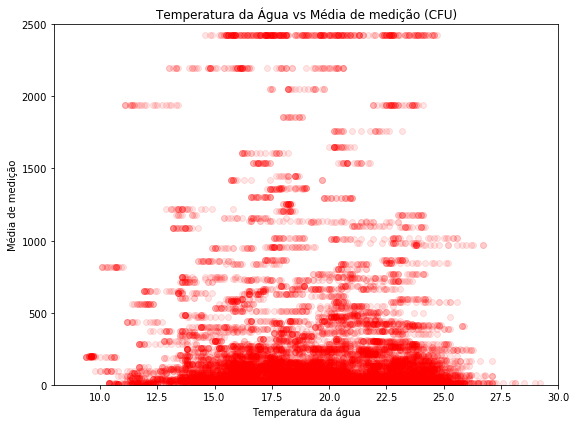

In [9]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.WtrTemperature, new_df.ReadingMean, c='red', alpha=0.1)
plt.title('Temperatura da Água vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Temperatura da água')


plt.tight_layout()
plt.axis([8,30,0,2500,])
plt.show()

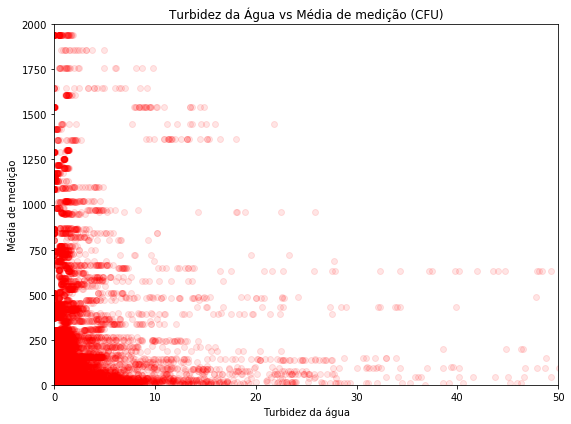

In [10]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.Turbidity, new_df.ReadingMean,  c='red', alpha=0.1)
plt.title('Turbidez da Água vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Turbidez da água')


plt.tight_layout()
plt.axis([0,50,0,2000])
plt.show()

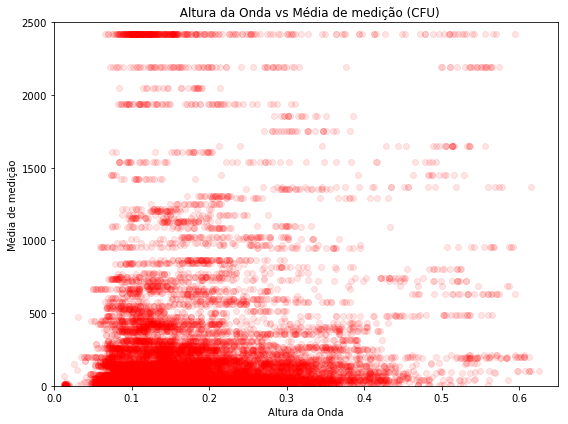

In [11]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.WaveHeight, new_df.ReadingMean, c='red', alpha=0.1)
plt.title('  Altura da Onda vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Altura da Onda')
plt.axis([0,0.65,0,2500])

plt.tight_layout()
plt.show()

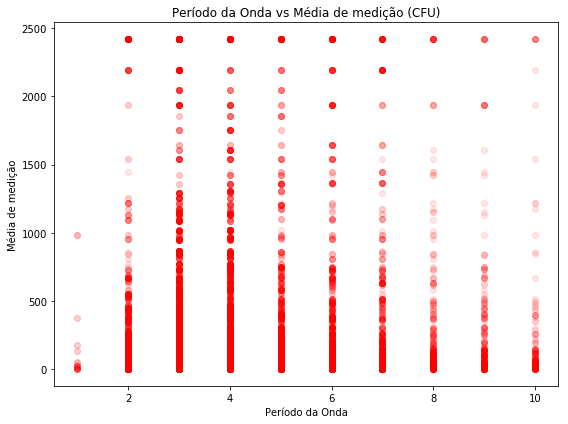

In [12]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.WavePeriod, new_df.ReadingMean,  c='red', alpha=0.1)
plt.title('Período da Onda vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Período da Onda')


plt.tight_layout()
plt.show()

Analisando os gráficos qualitativamente, é possível concluir que nenhuma das variáveis físicas plotadas parece ter relação com a concentração de bactérias na água, pelo menos não em duas dimensões. Ainda assim, para confirmar se podemos ou nao rejeitar H0, que indica que as variáveis das características físicas da água não têm correlação com a concentração de bactérias na água, vamos fazer um modelo de regressão linear.

# Regressão Linear


Vamos usar a função OLS() da biblioteca statsmodel

In [13]:
#rodando função OLS() da biblioteca statsmodel

Y = new_df['ReadingMean']
X = new_df[['WtrTemperature','Turbidity','WaveHeight','WavePeriod']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ReadingMean   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     120.8
Date:                Tue, 21 Nov 2017   Prob (F-statistic):          5.90e-102
Time:                        16:14:42   Log-Likelihood:            -1.3975e+05
No. Observations:               18556   AIC:                         2.795e+05
Df Residuals:                   18551   BIC:                         2.795e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            110.1474     22.709      4.850      0.000      65.635     154.660
WtrTemperature    -3.3543      0.966     -3.473      0.001      -5.247      -1.461
Turbidity         -0.5415      0.103     -5.276      0.000      -0.743      -0.340
WaveHeight       659.9825     36.089     18.288      0.000     589.245     730.721
WavePeriod        18.3985      2.048      8.984      0.000      14.384      22.413
==============================================================================
Omnibus:                    12753.923   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141522.956
Skew:                           3.330   Prob(JB):                         0.00
Kurtosis:                      14.777   Cond. No.                         371.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Os resultados da nossa regressão linear, extraídos da tabela, podem ser vistos abaixo:

$$\hat\beta_0 = 110.1474$$

$$\hat\beta_1 = -3.3543$$

$$\hat\beta_2 = -0.5415$$

$$\hat\beta_3 = 659.9825$$

$$\hat\beta_4 = 18.3985$$

Analisando esses valores, é possível perceber que nenhum vale exatamente 0, ou seja, nenhum valor nos leva a confirmar H0, mas será necessário fazer um teste de hipótese para ver se os devem ser rejeitados por serem muito improváveis de ocorrer, ou se  não devem ser rejeitados. Vamos fazer esse teste de hipótesea seguir.

Abaixo estão listados, extraídos da tabela, o valor-p de cada Beta:

#### Beta 0: 110.1474

Valor-p: 0.000


#### Beta 1: -3.3543

Valor-p: 0.001



#### Beta 2: -0.5415

Valor-p: 0.000



#### Beta 3: 659.9825

Valor-p: 0.000


#### Beta 4: 18.3985

Valor-p: 0.000


Percebe-se que os valores-p são extremamente pequenos. Abaixo, um valor com mais casas decimais foi calculado:

In [14]:
print(results.pvalues)

const             1.242853e-06
WtrTemperature    5.156832e-04
Turbidity         1.335660e-07
WaveHeight        4.650796e-74
WavePeriod        2.857141e-19
dtype: float64


Considerando os valores-p calculados, é possível perceber que é extremamente improvável que os valores de beta calculados aconteçam. Considerando um alfa com sensibilidade de 1%, os valores-p nos levam a rejeitar H0. Dessa forma, a conclusão é de que existe correlação, ou seja, as variáveis das características físicas da água têm correlação com a concentração de bactérias na água.

Apesar disso, a normal está muito deformada e assimétrica, então mesmo que rejeitemos H0 e consideremos que existe relação entre a quantidade de bactérias e características físicas da água, não podemos modelar a curva como sendo uma normal. Sinais de assimetria e deformação são, por exemplo, skew e kurtosis.


Skew é uma medida de assimetria. Com um valor de 3,330 indica uma "cauda" assimétrica com valores positivos, à direita, ou seja, com uma cauda maior para a direita. A distribuição normal ideal tem Skew = 0, e tem valores distribuídos igualmente à direita e à esquerda.

Kurtosis, por sua vez, é uma medida que indica a deformação do pico da distribuição. Com Kurtosis = 14.777, percebe-se que o pico da distribuição está muito mais elevado do que deveria estar em uma normal.


Ademais, para confirmar a falha gerada pelo modelo normal, é possível verificar como distribui-se a variável Y. De acordo com o Teorema do Limite Central, para um número n de amostras significativamente grande, a distribuição das amostras se aproxima da normal. Temos um n significativamente grande em nossa amostra, mas nem ela não se acomoda como uma normal: 



## Distribuição da Variável Dependente

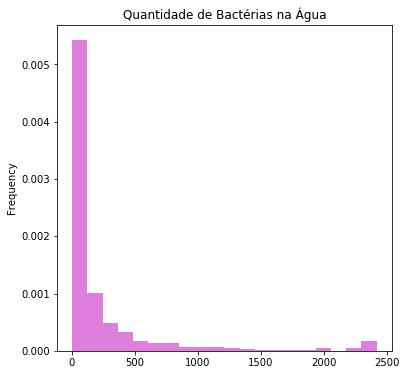

In [15]:
#plotagem gráficos

new_df.ReadingMean.plot.hist(bins=20,title='Quantidade de Bactérias na Água', figsize=(6, 6), normed=1, alpha=0.5, color='m')

In [16]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

X = new_df.iloc[:,3:6]
y = new_df.iloc[:,1]

X_train, X_test, y_train, y_test = train_test_split(X, y)


X_train, X_test, y_train, y_test = train_test_split(X, y, 
test_size=0.20, random_state=0)


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)


y_pred

array([ 170.74274173,  269.54589151,  196.48040336, ...,  193.27964572,
        200.98239675,  179.20026092])

In [17]:
math.sqrt(mean_squared_error(y_test, y_pred))

449.6461497083851

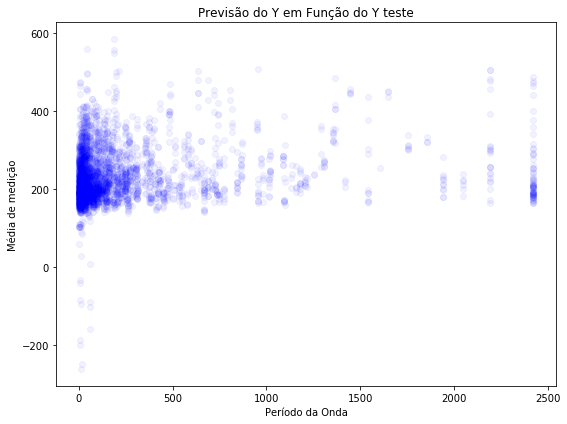

In [18]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,  c='blue', alpha=0.05)
plt.title('Previsão do Y em Função do Y teste')
plt.ylabel('Média de medição')
plt.xlabel('Período da Onda')


plt.tight_layout()
plt.show()

O gráfico confirma que as bactérias não se distribuem numa normal. Por conta disso, a regressão linear não é um modelo adequado para modelar as informações das nossas bases de dados. Uma segunda técnica de análise será abordada: uma Árvore de Decisão de Regressão.


# Árvore de Decisão

In [19]:
new_df.head(2)

,Beach,ReadingMean,Sample1TimeStamp,WtrTemperature,Turbidity,WaveHeight,WavePeriod,TimestampLabel
629,Montrose,844.0,2016-08-05,22.7,0.0,0.093,4.0,2016-08-05
630,Montrose,844.0,2016-08-05,22.7,0.0,0.097,8.0,2016-08-05


In [20]:
X = new_df.iloc[:,3:6]
y = new_df.iloc[:,1]

X_train, X_test, y_train, y_test = train_test_split(X, y)


X_train, X_test, y_train, y_test = train_test_split(X, y, 
test_size=0.20, random_state=0)

dt = DecisionTreeRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 5)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dt_fit.score(X_train, y_train)))

# on the test or hold-out set
from sklearn.metrics import r2_score
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))

mean cross validation score: -0.7501529421513319
score without cv: 0.9961676555369445
-0.507135042132
-0.507135042132


In [21]:
y_pred=dt.predict(X_test)
y_pred

array([   16.5,  1304.2,   127.9, ...,     6.7,   531.6,    39. ])

In [22]:
math.sqrt(mean_squared_error(y_test, y_pred))

559.1621145766483

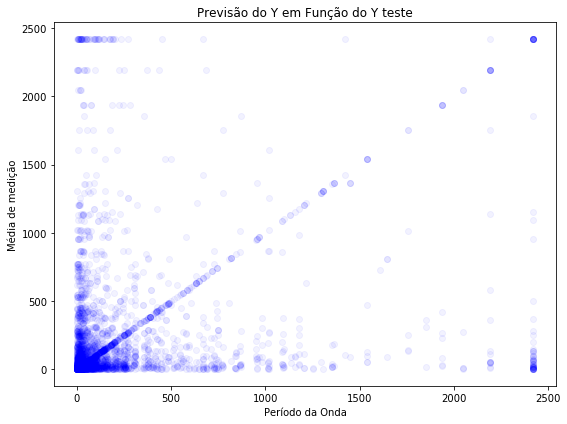

In [23]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,  c='blue', alpha=0.05)
plt.title('Previsão do Y em Função do Y teste')
plt.ylabel('Média de medição')
plt.xlabel('Período da Onda')


plt.tight_layout()
plt.show()

In [24]:
from sklearn.datasets import load_iris
from sklearn import tree

sklearn.tree.export_graphviz(decision_tree, out_file=”tree.dot”, max_depth=None, feature_names=None, class_names=None, label=’all’, filled=False, leaves_parallel=False, impurity=True, node_ids=False, proportion=False, rotate=False, rounded=False, special_characters=False, precision=3)

SyntaxError: invalid character in identifier (<ipython-input-24-92384bfddfe2>, line 4)